In [1]:
import networkx as nx

#synteny_map = nx.read_gexf("/home/cadel/synteny/synteny.gexf")

In [2]:
from deduce_uces.io.sam import parse_sam_lazy
from deduce_uces.Logger import ConsoleLogger
#sam_filename = "/home/cadel/synteny/sandy.v0a.0.canu.85e72ca32167c8624f2dc602fba8b3ee.sam"
#alignments = [a for a in parse_sam_lazy(sam_filename, 0, ConsoleLogger(), False)]

In [3]:
import itertools
from operator import attrgetter

# syntenic = 0
# non_syntenic = 0

# def is_pair_syntenic(pair, map):
#     # print("syn?",pair[0].query_name,
#     if synteny_map.get_edge_data(pair[0].query_name, pair[1].query_name, {"weight": 0})["weight"] > 0:
#         return True
#     return False

# for _, uces in itertools.groupby(sorted(alignments, key=attrgetter("reference_name")), key=attrgetter("reference_name")):
#     sorted_uces = list(sorted(uces, key=attrgetter("position")))
    
#     for i in range(len(sorted_uces) - 1):
#         pair = (sorted_uces[i], sorted_uces[i+1])
#         #print(pair)
#         if is_pair_syntenic(pair):
#             syntenic += 1
#         else:
#             non_syntenic += 1

In [56]:
import csv
from operator import itemgetter

def sort_and_group(xs, by):
    for g, gxs in itertools.groupby(sorted(xs, key=by), key=by):
        yield g, list(gxs)

def build_simple_synteny_map(bed_file):
    with open(bed_file) as f:
        r = csv.reader(f, delimiter="\t")
        
        uces = [(line[3], line[0], int(line[1])) for line in r]
    
    unique_uces = get_unique_uces(uces)
    
    m = nx.DiGraph()
    for contig, contig_uces in sort_and_group(unique_uces, itemgetter(1)):
        sorted_contig_uces = sorted(contig_uces, key=itemgetter(2))
        
        for i in range(len(sorted_contig_uces) - 1):
            m.add_node(sorted_contig_uces[i][0])
            m.add_node(sorted_contig_uces[i+1][0])
            m.add_edge(sorted_contig_uces[i][0], sorted_contig_uces[i+1][0], weight=1,dist=sorted_contig_uces[i+1][2] - sorted_contig_uces[i][2])
    return m
        


In [57]:
def get_unique_uces(uces):
    unique = []
    for uce_id, instances in sort_and_group(uces, itemgetter(0)):
        if len(instances) > 1:
            continue
        unique.append(instances[0])
    return unique

def read_unique_uces_from_sam(sam_filename, max_mismatches = 0):
    uces = [(a.query_name, a.reference_name, a.position) for a in parse_sam_lazy(sam_filename, max_mismatches, ConsoleLogger(), False)]
    return get_unique_uces(uces)
    

def scored_shortest_path_or_none(g, x, y, max_len):
    if x not in g:
        return None, None
    if y not in g:
        return None, None
    
    try:
        p = nx.shortest_path(g, source=x, target=y)
        if len(p) > max_len:
            return None, None
        
        consensus = []
        for i in range(len(p) - 1):
            consensus.append(g[p[i]][p[i+1]]["weight"])
        return min(consensus) * (1/len(p)), len(p)
    
    except nx.NetworkXNoPath:
        return None, None
    
def assess_synteny_by_pairs(uces, synteny_map, max_dist=1):
    syntenic = 0
    score = 0
    for _, contig_uces in sort_and_group(uces, itemgetter(1)):
        sorted_uces = list(sorted(contig_uces, key=itemgetter(2)))

        for i in range(len(sorted_uces) - 1):
            pair = (sorted_uces[i], sorted_uces[i+1])
            s, d = scored_shortest_path_or_none(synteny_map, pair[0][0], pair[1][0], max_dist)
            if s and d:
                score += s
                syntenic += 1
    return syntenic, score

In [58]:
def merge_synteny_maps(maps):
    merged = nx.DiGraph()
    
    for m in maps:
        for n in m.nodes:
            merged.add_node(n)
    
    for m in maps:
        for e in m.edges(data="weight"):
            if merged.has_edge(e[0], e[1]):
                merged[e[0]][e[1]]["weight"] = merged[e[0]][e[1]]["weight"] + m[e[0]][e[1]]["weight"]
            else:
                merged.add_edge(e[0], e[1], weight=m[e[0]][e[1]]["weight"])
    
    return merged

In [59]:
maps = [build_simple_synteny_map(x) for x in [
    "/home/cadel/synteny/ste08_5_of_5_1c77a9f-bosTau2.bed",
    "/home/cadel/synteny/ste08_5_of_5_1c77a9f-canFam2.bed",
    "/home/cadel/synteny/ste08_5_of_5_1c77a9f-hg18.bed",
    "/home/cadel/synteny/ste08_5_of_5_1c77a9f-mm8.bed",
    "/home/cadel/synteny/ste08_5_of_5_1c77a9f-rn4.bed"
]]

In [66]:
consensus = merge_synteny_maps(maps)
len(consensus)

2848

In [70]:
assess_synteny_by_pairs(read_unique_uces_from_sam("/home/cadel/synteny/sandy.v2.2.5a6fcc90597a01ded81ff52f9c01586d.sam"), consensus, max_dist=100)

(2779, 4371.407491774734)

In [62]:
import seaborn as sns
import pandas as pd

records = []
for distance_threshold in range(1,101):
    found, score = assess_synteny_by_pairs(read_unique_uces_from_sam("/home/cadel/synteny/sandy.v2.2.e45e1bd7ff314c5330389689134e13ce.sam"), consensus, max_dist=distance_threshold)
    records.append((distance_threshold, found, score))
    
pair_df = pd.DataFrame.from_records(records, columns=["distance", "n", "score"])
    

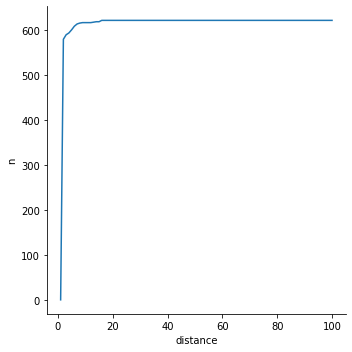

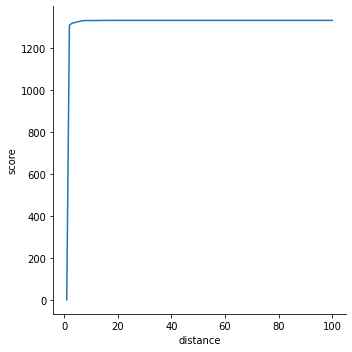

In [63]:
sns.relplot(data=pair_df, x="distance", y="n", kind="line")
sns.relplot(data=pair_df, x="distance", y="score", kind="line")

In [65]:
import os
sams = [
    "sandy.v0a.0.canu.5a35c4c62cacaa136f779fb23df34815.sam",
    "sandy.v0a.1.arrow.5df39d56c85da00b8b3e43fa09962497.sam",
    "sandy.v0a.2.purged.e95feb9a73fc440ca0a51f6f988609ab.sam",
    "sandy.v0a.3.hic.8d7516ee7e5fdeef7afd143c204f4d9e.sam",
    "sandy.v0a.4.arrow2.ea78c4d82029da7d403aa67243af14b7.sam",
    "sandy.v0a.5.pbjelly.849c05c809e876245ac851df5b91c6ac.sam",
    "sandy.v0a.6.arrow3.e3ed87121b0a024c55bab7cd36d48cd1.sam",
    "sandy.v0a.7.pilon.4ae9e36ba7614a163ffcc4f07a15c72c.sam",
    "sandy.v0a.8.pafscaff.709b7f4cbe1fab56f026c72d66476e9b.sam",
    "sandy.v2.0.9a58047bd2b428208d7f2edba473b209.sam"
    ]

for sam in sams:
    found, score = assess_synteny_by_pairs(read_unique_uces_from_sam(os.path.join("/home/cadel/synteny/sandy/fasta/fasta", sam)), consensus, max_dist=5)
    print(sam, found, score)


sandy.v0a.0.canu.5a35c4c62cacaa136f779fb23df34815.sam 295 489.6833333333333
sandy.v0a.1.arrow.5df39d56c85da00b8b3e43fa09962497.sam 313 519.3666666666666
sandy.v0a.2.purged.e95feb9a73fc440ca0a51f6f988609ab.sam 312 515.6999999999998
sandy.v0a.3.hic.8d7516ee7e5fdeef7afd143c204f4d9e.sam 420 829.7666666666667
sandy.v0a.4.arrow2.ea78c4d82029da7d403aa67243af14b7.sam 419 827.2666666666667
sandy.v0a.5.pbjelly.849c05c809e876245ac851df5b91c6ac.sam 442 872.5166666666668
sandy.v0a.6.arrow3.e3ed87121b0a024c55bab7cd36d48cd1.sam 441 870.0166666666668
sandy.v0a.7.pilon.4ae9e36ba7614a163ffcc4f07a15c72c.sam 443 875.8500000000001
sandy.v0a.8.pafscaff.709b7f4cbe1fab56f026c72d66476e9b.sam 601 1328.133333333333
sandy.v2.0.9a58047bd2b428208d7f2edba473b209.sam 601 1328.133333333333


In [55]:
# Starling
starling_maps = [build_simple_synteny_map(x) for x in [
    "/home/cadel/projects/thesis/UNSWThesis/data/completeness/starling/synteny/5484b21-aquila_chrysaetos_chrysaetos.bed",
    "/home/cadel/projects/thesis/UNSWThesis/data/completeness/starling/synteny/5484b21-struthio_camelus_australis.bed",
    "/home/cadel/projects/thesis/UNSWThesis/data/completeness/starling/synteny/5484b21-parus_major.bed",
]]

starling_consensus = merge_synteny_maps(starling_maps)

starling_sams = [
    "step1_svulgaris-10x-550M-sub80.1.016b695fb029277df04852a0c0dfdde2.sam",
    "step8_pseudochromosomes.2cbb6c3061a899aba45374a34b16ad00.sam"
]

for sam in starling_sams:
    found, score = assess_synteny_by_pairs(read_unique_uces_from_sam(os.path.join("/home/cadel/synteny", sam)), starling_consensus, max_dist=100)
    print(sam, found, score)

    
for m in starling_maps:
    found, score = assess_synteny_by_pairs(read_unique_uces_from_sam(os.path.join("/home/cadel/synteny", sam)), m, max_dist=100)
    print(sam, found, score)

step1_svulgaris-10x-550M-sub80.1.016b695fb029277df04852a0c0dfdde2.sam 1087 133.25983045143957
step8_pseudochromosomes.2cbb6c3061a899aba45374a34b16ad00.sam 1224 156.14011438188686
step8_pseudochromosomes.2cbb6c3061a899aba45374a34b16ad00.sam 379 16.187420782960203
step8_pseudochromosomes.2cbb6c3061a899aba45374a34b16ad00.sam 1105 102.87169930763991
step8_pseudochromosomes.2cbb6c3061a899aba45374a34b16ad00.sam 357 17.82499340319275
